In [132]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.distributions import MultivariateNormal, Normal
from torchvision.transforms import ToTensor

from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *

In [133]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

%load_ext autoreload
%autoreload 2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [134]:
#DEVICE = 'cpu'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [135]:
DATAPATH = 'C:/Users/matan/Documents/data/coil-20-proc'
root_dir = DATAPATH + '/coil-20-proc'
csv_file = 'C:/Users/matan/Documents/data/coil-20-proc/labels.csv'

In [136]:
df = pd.read_csv(csv_file)

In [154]:
class COIL20(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        self.labels = range(1,21)
        self.objects = ["Rubber duck",
            "Wooden toy 1",
            "Toy car 1",
            "Lucky cat",
            "Anacin",
            "Toy car 2",
            "Wooden toy 2",
            "Johnsons baby powder",
            "Tylenol",
            "Vaseline",
            "Wooden toy 3",
            "Chinese cup",
            "Piggy bank",
            "Connector",
            "Plastic container",
            "Conditioner bottle",
            "Ceramic pot",
            "Teacup",
            "Toy car 3",
            "Philadelphia"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['image'], row['label']
        img_filename = self.root_dir + '/' + str(img_id)
        img = Image.open(img_filename)
        if self.transform:
            img = self.transform(img)
        return img, img_label

Number of images in the dataset:  1440
Image shape: torch.Size([1, 128, 128])


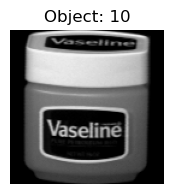

In [155]:
dataset = COIL20(root_dir, csv_file, transform=ToTensor())
print("Number of images in the dataset: ", len(dataset))
img, label = dataset[0]
print("Image shape:", img.shape)

plt.figure(figsize=(2,2))
plt.imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
plt.title("Object: " + str(label))
plt.axis('off')
plt.show()

# Set parameters

In [139]:
# Hyperparameters
batch_size = 64
lr = 0.001

N = len(dataset)
in_channels = 1
input_size = [in_channels, 128, 128]
dim_input = np.prod(input_size)
dim_hidden = 1024
dim_latent = 2
n_classes = 20
seed = 11       # Random seed for reproducible results
torch.manual_seed(seed);

In [156]:
# Divide into train, test, and val
test_size = int(0.1*N)
val_size = int(0.1*N)
train_size = N - test_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
print("Training images: ", len(train_data))
print("Validation images: ", len(val_data))
print("Test images: ", len(test_data))

#kwargs = {'num_workers': 1, 'pin_memory': True} 
kwargs = {}
train_loader = DataLoader(train_data, batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, len(test_data), **kwargs)
val_loader = DataLoader(val_data, len(val_data), **kwargs)

Training images:  1152
Validation images:  144
Test images:  144


In [141]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


# Make and train VAE model

In [142]:
from multiprocessing import reduction


class Encoder(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_latent):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.mu = nn.Linear(dim_hidden, dim_latent)
        self.var = nn.Linear(dim_hidden, dim_latent)

        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)   # Flatten image
        h1 = self.activation(self.fc1(x))
        h1 = self.activation(self.fc2(h1))
        return self.mu(h1), self.var(h1)


class Decoder(nn.Module):
    def __init__(self, dim_latent, dim_hidden, dim_input):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(dim_latent, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.fc3 = nn.Linear(dim_hidden, dim_input)
        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()

    def forward(self, z):
        h1 = self.activation(self.fc1(z))
        h1 = self.activation(self.fc2(h1))
        #return self.mu(h1), self.var(h1)
        return torch.tanh(self.fc3(h1))


class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparametrization(self, mean, var):
        eps = torch.randn_like(var).to(DEVICE) # Ransom tensor in same shape as var
        z = mean + var*eps
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        std = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, std)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

    def get_latents(self, x):
        """ Encode data x into latent representations z. """
        mean, log_var = self.Encoder(x)
        std = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, std)
        return z


def loss_function(x, out, mean, log_var, beta = 1):
    """ Loss function for the model. """
    x_hat=out
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KL_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    KL_divergence = KL_divergence * beta
    #print("Loss:", reproduction_loss, KL_divergence)
    return reproduction_loss + KL_divergence, reproduction_loss, KL_divergence

In [143]:
def beta_func(step, start=200, stop=400, scale=0.8):
    if step < start:
        return 0
    elif step > stop:
        return scale
    else: 
        return scale * (step - start)/(stop - start)

In [144]:
encoder = Encoder(dim_input, dim_hidden, dim_latent).to(DEVICE)
decoder = Decoder(dim_latent, dim_hidden, dim_input).to(DEVICE)
model = Model(encoder, decoder).to(DEVICE)
optimizer = Adam(model.parameters(), lr=lr)
print(DEVICE)

cuda


In [145]:
# Train the model
epochs = 50
validation_loss = []
train_losses = []
train_r_losses = []
train_kl_losses = []
beta_vals = []
step = 0
for epoch in range(epochs):
    model.train()
    loss_this_epoch = 0
    r_loss_this_epoch = 0
    kl_loss_this_epoch = 0
    for batch, (x, label) in enumerate(train_loader):
        batch_size = x.shape[0]
        x = x.view(batch_size, dim_input)   # Flatten
        x = x.to(DEVICE)

        assert not torch.isnan(x).any()
        optimizer.zero_grad()

        out, mean, logvar = model(x)
        x_hat = out

        if torch.isnan(x_hat.view(-1)).sum().item() != 0:
            print("Number of nans:", torch.isnan(x_hat.view(-1)).sum().item())
            print(x_hat)
        assert not torch.isnan(x_hat).any()
        
        #loss = loss_function(x, out, q_mean, q_log_var)
        beta = beta_func(step)
        loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=beta)
        loss_this_epoch += loss.item() 
        r_loss_this_epoch += r_loss.item()
        kl_loss_this_epoch += kl.item()
        beta_vals.append(beta)
        step += 1


        loss.backward()
        optimizer.step()

    train_losses.append(loss_this_epoch / ((batch+1)*batch_size))
    train_r_losses.append(r_loss_this_epoch / ((batch+1)*batch_size))
    train_kl_losses.append(kl_loss_this_epoch / ((batch+1)*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", loss_this_epoch / ((batch+1)*batch_size))
    print("\t\t\t\tReproduction loss:", r_loss_this_epoch / ((batch+1)*batch_size) ,"\tKL-div:", kl_loss_this_epoch / ((batch+1)*batch_size))

    # model.eval()
    # with torch.no_grad():
    #     x_hat, q_mean, q_log_var = model(val_data)
    #     loss = loss_function(val_data, x_hat, q_mean, q_log_var)
    #     validation_loss.append(loss.item() / len(val_data))

	Epoch 1 complete! 	Average Loss:  3007.167032877604
				Reproduction loss: 3007.167032877604 	KL-div: 0.0
	Epoch 2 complete! 	Average Loss:  954.6260952419705
				Reproduction loss: 954.6260952419705 	KL-div: 0.0
	Epoch 3 complete! 	Average Loss:  727.8877156575521
				Reproduction loss: 727.8877156575521 	KL-div: 0.0
	Epoch 4 complete! 	Average Loss:  669.881357828776
				Reproduction loss: 669.881357828776 	KL-div: 0.0
	Epoch 5 complete! 	Average Loss:  653.2512749565972
				Reproduction loss: 653.2512749565972 	KL-div: 0.0
	Epoch 6 complete! 	Average Loss:  654.8115437825521
				Reproduction loss: 654.8115437825521 	KL-div: 0.0
	Epoch 7 complete! 	Average Loss:  639.17041015625
				Reproduction loss: 639.17041015625 	KL-div: 0.0
	Epoch 8 complete! 	Average Loss:  628.858164469401
				Reproduction loss: 628.858164469401 	KL-div: 0.0
	Epoch 9 complete! 	Average Loss:  630.3610297309028
				Reproduction loss: 630.3610297309028 	KL-div: 0.0
	Epoch 10 complete! 	Average Loss:  636.41883

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


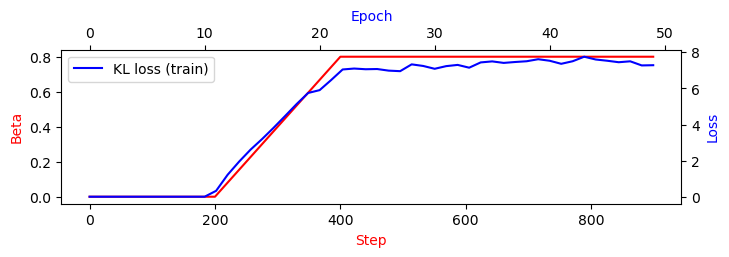

In [146]:
fig = plt.figure(figsize=(8,2))
ax1 = fig.add_subplot(111, label='1')
ax2 = fig.add_subplot(111, label='2', frame_on=False)

ax1.plot(range(step), beta_vals, color='red', label = "Beta")
ax1.set_xlabel("Step", color='red')
ax1.set_ylabel("Beta", color='red')
plt.legend()

ax2.plot(range(epochs), train_kl_losses, color='blue', label = "KL loss (train)")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel("Epoch", color='blue')
ax2.set_ylabel("Loss", color='blue')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
plt.legend()
plt.show()

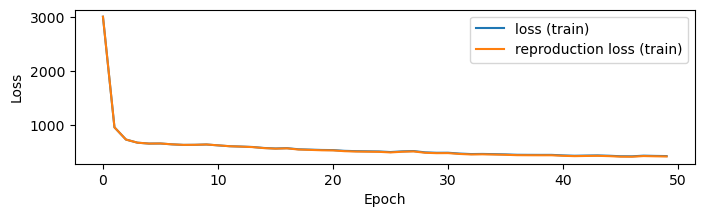

In [147]:
plt.figure(figsize=(8,2))
plt.plot(range(epochs), train_losses, label = "loss (train)")
plt.plot(range(epochs), train_r_losses, label = "reproduction loss (train)")
#plt.plot(range(epochs), validation_loss, label = 'validation_loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

# Evaluate the model

<Figure size 400x200 with 0 Axes>

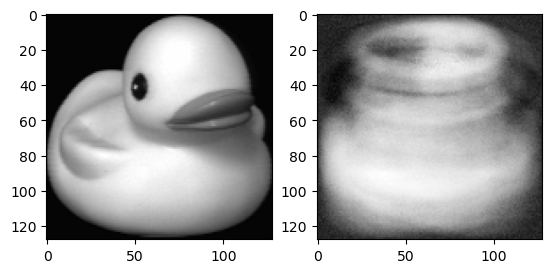

In [148]:
model.eval()

# See reconstruction of an image in the training set
img, label = train_data[900]
img_repro, _, _ = model(img.to(DEVICE))
img_repro = img_repro.reshape(input_size).cpu().detach()
plt.figure(figsize=(4,2))
fig, axs = plt.subplots(1,2)
axs[0].imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
axs[1].imshow(img_repro.permute(1,2,0), cmap=plt.get_cmap('gray'))
plt.show()

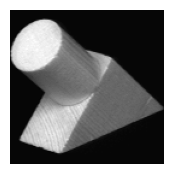

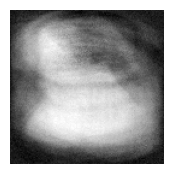

In [149]:
model.eval()
examples = enumerate(test_loader)
with torch.no_grad():
    batch, (x, labels) = next(examples)
    x = x.view(x.size(0), dim_input)
    x = x.to(DEVICE)
    x_hat, _, _ = model(x)

def show_image_in_batch(images, idx):
    images = images.view(images.shape[0], input_size[-2], input_size[-1])
    fig = plt.figure(figsize=(2,2))
    plt.imshow(images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

show_image_in_batch(x, idx=0)
show_image_in_batch(x_hat, idx=0)

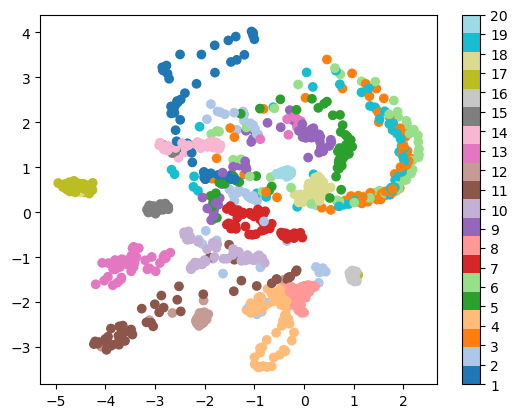

In [165]:
plot_latent_space2d(model, train_loader, n_batches=200)

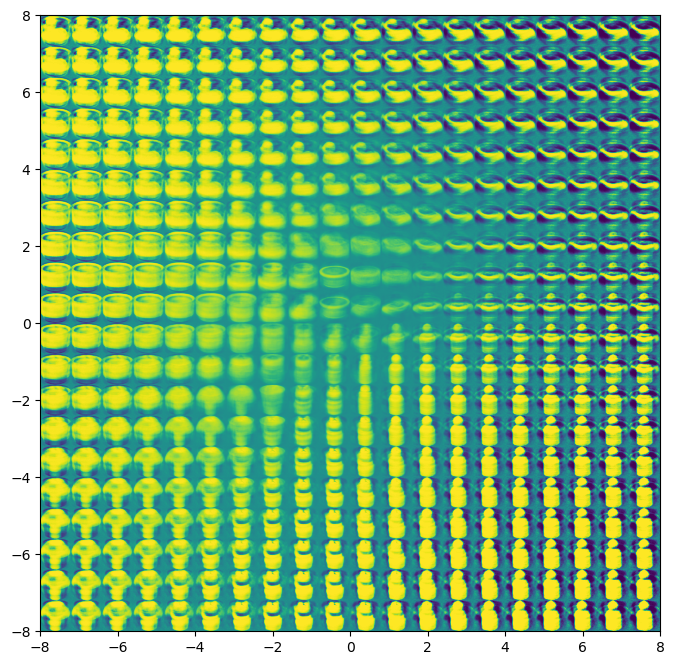

In [151]:
plot_reconstructed(model, ax0=(-8,8), ax1=(-8,8), n=20, img_size=input_size[-2:])

In [159]:
print(train_loader.dataset.labels)

AttributeError: 'Subset' object has no attribute 'labels'